In [2]:
import zarr
from skimage.morphology import opening, remove_small_objects, closing, rectangle, disk, dilation, erosion
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops_table
from tqdm import tqdm
import numpy as np
from joblib import Parallel, delayed

In [3]:
z1 = zarr.open('/home/rl627/SSD1/20230824_SB8_TY009_sytox/masks.zarr', mode='r')
print(z1.shape)

(27, 2161, 3, 928, 128)


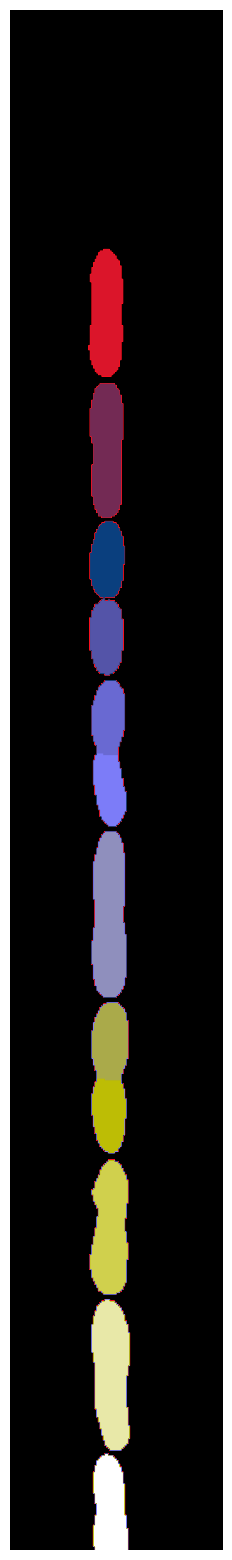

In [4]:
fig=plt.figure(figsize=(10, 20))
fov = 17
timepoint = 558
plt.imshow(z1[fov, timepoint, 0, :, :], cmap='gist_stern')
plt.axis('off')
plt.show()

In [5]:
mask = z1[fov, timepoint, 0, :, :]

def correction(mask, min_size):
    mask = mask.astype(bool)

    filtered = remove_small_objects(mask, min_size=min_size)

    width = int(mask.shape[1]/10)
    height = int(mask.shape[1]/25)
    X, Y = np.ogrid[0:width*2+1, 0:height*2+1]

    footprint1 = (1./4 * (X - width)**2 + (Y - height)**2 < height**2).astype(np.uint8)
    sep = erosion(filtered, footprint1)

    labels = dilation(label(sep, connectivity=1), footprint1)
    return labels

labels = correction(mask, 30)
# labels = label(filtered, connectivity=1)

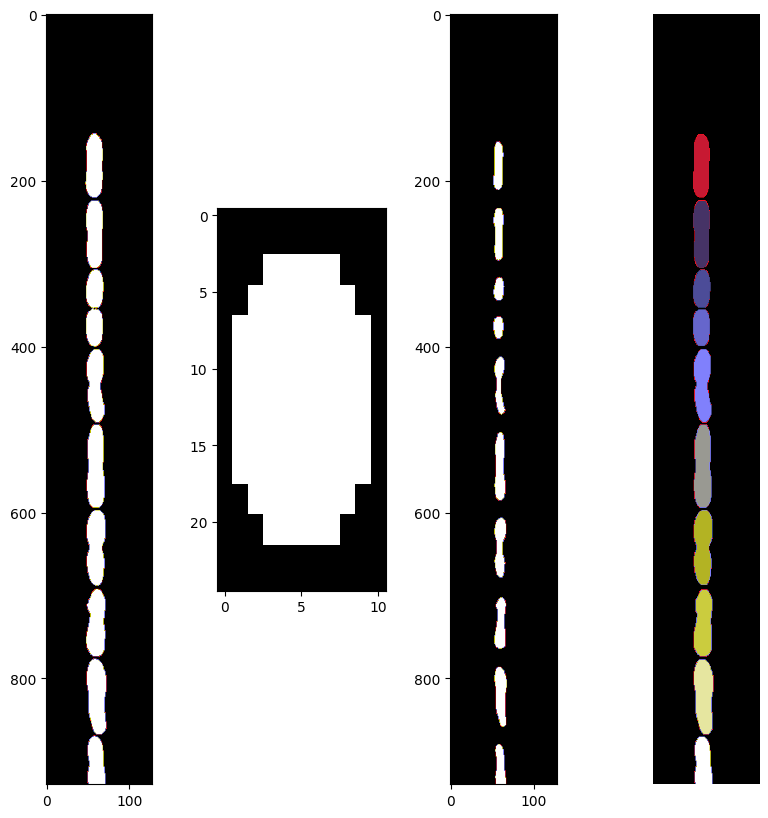

In [6]:
mask = mask.astype(bool)
filtered = remove_small_objects(mask, min_size=30)
width = int(mask.shape[1]/10)
height = int(mask.shape[1]/25)
X, Y = np.ogrid[0:width*2+1, 0:height*2+1]
footprint1 = (1./4 * (X - width)**2 + (Y - height)**2 < height**2).astype(np.uint8)
sep = erosion(filtered, footprint1)
labels = dilation(label(sep, connectivity=1), footprint1)

fig = plt.figure(figsize=(10, 10))
plt.subplot(1, 4, 1)
plt.imshow(mask, cmap='gist_stern')
plt.subplot(1, 4, 2)
plt.imshow(footprint1, cmap='gist_stern')
plt.subplot(1, 4, 3)
plt.imshow(sep, cmap='gist_stern')
plt.subplot(1, 4, 4)
plt.imshow(labels, cmap='gist_stern')
plt.axis('off')
plt.show()

In [7]:
# mask = z1[fov, timepoint, :, :, :]

# def correction(mask):
#     print(mask.shape)
#     mask = mask.astype(bool)

#     filtered = remove_small_objects(mask, min_size=30, connectivity=1)

#     width = int(mask.shape[2]/10)
#     height = int(mask.shape[2]/25)
#     X, Y = np.ogrid[0:width*2+1, 0:height*2+1]

#     footprint1 = (1./4 * (X - width)**2 + (Y - height)**2 < height**2).astype(np.uint8)
#     footprint_3d = np.array([footprint1, footprint1, footprint1])
#     print(footprint_3d.shape)
#     sep = erosion(filtered, footprint_3d)

#     labels = dilation(label(sep, connectivity=1), footprint1)
#     return labels

# labels = correction(mask)

In [8]:
def pre_proc_seg_error(mask_path, save_path, min_size=0): 
    # use information from PC or fluo images?
    z1 = zarr.open(mask_path, mode='r')
    # z2 = zarr.open(save_path, mode='w')
    z2_shape = z1.shape[:2] + (1,) + z1.shape[3:]
    z2 = zarr.zeros(z2_shape, chunks=z1.chunks[:2] + (1,) + z1.chunks[3:])
    print(z2.shape)
    # Parallel processing part
    def process_and_save(i, j, min_size=min_size):
        mask_image = z1[i, j, 0, :, :]
        corrected_image = correction(mask_image, min_size)
        z2[i, j, 0, :, :] = corrected_image
        
    all_indices = [(i, j) for i in range(z1.shape[0]) for j in range(z1.shape[1])]
    
    Parallel(n_jobs=-1, require='sharedmem')(delayed(process_and_save)(i, j) 
                                             for i, j in tqdm(all_indices, desc="Processing images"))
    
    zarr.save(save_path, z2)
    return f"saved to {save_path}"

In [9]:
pre_proc_seg_error('/home/rl627/SSD1/20230824_SB8_TY009_sytox/masks.zarr',
                   '/home/rl627/SSD1/20230824_SB8_TY009_sytox/masks_proc_2.zarr', 
                   min_size=100)

(27, 2161, 1, 928, 128)


Processing images: 100%|█████████████████| 58347/58347 [04:03<00:00, 239.16it/s]


'saved to /home/rl627/SSD1/20230824_SB8_TY009_sytox/masks_proc_2.zarr'